<a href="https://colab.research.google.com/github/sayannath/Image-Scene-Classification/blob/master/Scene_Detection_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Gathering

In [ ]:
!wget -q http://data.vision.ee.ethz.ch/ihnatova/camera_scene_detection_train.zip
!unzip -qq camera_scene_detection_train.zip

## Initial Setup

In [2]:
!nvidia-smi

Mon Mar  1 05:15:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.4.1


In [39]:
from imutils import paths
from pprint import pprint
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(42)

## Data EDA and Parsing

In [5]:
image_paths = list(paths.list_images("training"))
np.random.shuffle(image_paths)
image_paths[:5]

['training/14_Architecture/402.jpg',
 'training/23_Fireworks/74.jpg',
 'training/9_Mountain/200.jpg',
 'training/18_Greenery/20.jpg',
 'training/3_Kids/253.jpg']

In [10]:
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count) 

Counter({'4_Dog': 502,
         '14_Architecture': 463,
         '15_Sunset_Sunrise': 420,
         '7_Food': 400,
         '5_Cat': 373,
         '6_Macro': 357,
         '9_Mountain': 352,
         '11_Snow': 344,
         '12_Landscape': 335,
         '8_Beach': 334,
         '10_Waterfall': 326,
         '2_Group_portrait': 324,
         '16_Blue_Sky': 322,
         '22_Stage_concert': 322,
         '1_Portrait': 319,
         '23_Fireworks': 317,
         '21_Night_shot': 316,
         '24_Candle_light': 313,
         '30_Computer_Screens': 308,
         '17_Cloudy_Sky': 307,
         '28_Text_Documents': 306,
         '26_Indoor': 298,
         '13_Underwater': 296,
         '19_Autumn_leaves': 295,
         '18_Greenery': 294,
         '3_Kids': 281,
         '27_Backlight': 280,
         '20_Flower': 279,
         '25_Neon_lights': 269,
         '29_QR_images': 245})


In [42]:
TRAIN_SPLIT = 0.9
IMG_SIZE = 224
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
EPOCHS = 100

In [16]:
i = int(len(image_paths) * TRAIN_SPLIT)

train_paths = image_paths[:i]
train_labels = labels[:i]
validation_paths = image_paths[i:]
validation_labels = labels[i:]

print(len(train_paths), len(validation_paths))

8907 990


In [18]:
le = LabelEncoder()
train_labels_le = le.fit_transform(train_labels)
validation_labels_le = le.transform(validation_labels)
print(train_labels_le[:5])

[ 4 14 29  8 23]


## Data Loader Utilities

In [28]:
@tf.function
def load_images(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return (image, label)

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
        tf.keras.layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [31]:
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_le))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)
val_ds = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels_le))
val_ds = (
    val_ds
    .map(load_images, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

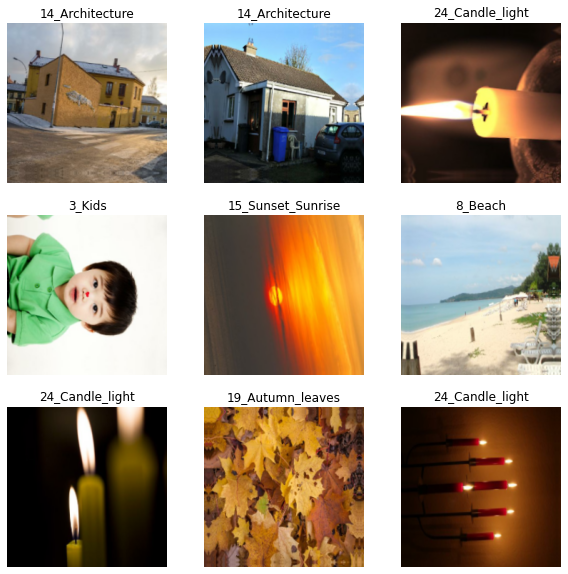

In [36]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    label = label_batch[i]
    plt.title(le.inverse_transform([label.numpy()])[0])
    plt.axis("off")

Since the dataset has class imbalance issue, it's good supply class weights while training the model. 

In [38]:
# Reference: https://www.pyimagesearch.com/2019/02/18/breast-cancer-classification-with-keras-and-deep-learning/
trainLabels = to_categorical(train_labels_le)
classTotals = trainLabels.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

## Model Building and Training

In [45]:
def get_training_model(trainable=False):
    # Load the MobileNetV2 model but exclude the classification layers
    EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))
    # We will set it to both True and False
    EXTRACTOR.trainable = trainable
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(30, activation="softmax")(class_head)

    # Create the new model
    classifier = tf.keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [46]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()

In [47]:
train_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

Epoch 1/100
140/140 [==============================] - 81s 550ms/step - loss: 2.3901 - accuracy: 0.5851 - val_loss: 0.4437 - val_accuracy: 0.8737
Epoch 2/100
140/140 [==============================] - 76s 541ms/step - loss: 0.7242 - accuracy: 0.8594 - val_loss: 0.4118 - val_accuracy: 0.8697
Epoch 3/100
140/140 [==============================] - 76s 532ms/step - loss: 0.5677 - accuracy: 0.8872 - val_loss: 0.3631 - val_accuracy: 0.8929
Epoch 4/100
140/140 [==============================] - 76s 532ms/step - loss: 0.4889 - accuracy: 0.9028 - val_loss: 0.3571 - val_accuracy: 0.8879
Epoch 5/100
140/140 [==============================] - 76s 531ms/step - loss: 0.4237 - accuracy: 0.9107 - val_loss: 0.3714 - val_accuracy: 0.8879
Epoch 6/100
140/140 [==============================] - 75s 528ms/step - loss: 0.3995 - accuracy: 0.9136 - val_loss: 0.3525 - val_accuracy: 0.8960
Epoch 7/100
140/140 [==============================] - 76s 533ms/step - loss: 0.3917 - accuracy: 0.9206 - val_loss: 0.3435 -

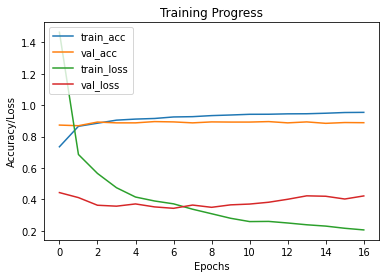

In [50]:
classifier = get_training_model()
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)
accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

In [52]:
# LR schedule
# Reference: https://t.ly/IT9G
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
train_callbacks.extend([lr_callback])

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
140/140 [==============================] - 79s 538ms/step - loss: 0.2962 - accuracy: 0.9391 - val_loss: 0.3535 - val_accuracy: 0.8990
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
140/140 [==============================] - 76s 538ms/step - loss: 0.2608 - accuracy: 0.9458 - val_loss: 0.3212 - val_accuracy: 0.9040
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
140/140 [==============================] - 75s 527ms/step - loss: 0.2521 - accuracy: 0.9485 - val_loss: 0.3364 - val_accuracy: 0.8990
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
140/140 [==============================] - 75s 524ms/step - loss: 0.2308 - accuracy: 0.9534 - val_loss: 0.3839 - val_accuracy: 0.8960
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000

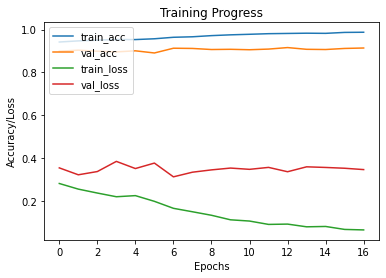

In [54]:
for layer in classifier.layers[-20:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
classifier.compile(loss="sparse_categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"])
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)
accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
140/140 [==============================] - 80s 546ms/step - loss: 0.1393 - accuracy: 0.9704 - val_loss: 0.3431 - val_accuracy: 0.9040
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
140/140 [==============================] - 75s 535ms/step - loss: 0.1558 - accuracy: 0.9641 - val_loss: 0.3491 - val_accuracy: 0.9111
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 2.6000000000000002e-05.
140/140 [==============================] - 75s 530ms/step - loss: 0.1314 - accuracy: 0.9693 - val_loss: 0.3537 - val_accuracy: 0.9101
Epoch 4/100

Epoch 00004: LearningRateScheduler reducing learning rate to 3.4000000000000007e-05.
140/140 [==============================] - 75s 531ms/step - loss: 0.1557 - accuracy: 0.9670 - val_loss: 0.3154 - val_accuracy: 0.9030
Epoch 5/100

Epoch 00005: LearningRateScheduler reducing learning rate to 4.2000000000000

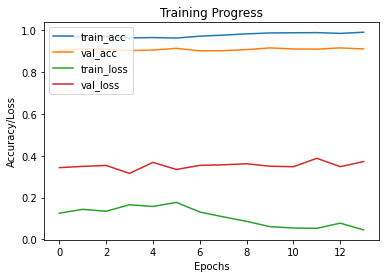

In [55]:
for layer in classifier.layers[-40:-20]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True
classifier.compile(loss="sparse_categorical_crossentropy", 
    optimizer="adam",
    metrics=["accuracy"])
h = classifier.fit(train_ds,
               validation_data=val_ds,
               epochs=EPOCHS,
               class_weight=classWeight,
               callbacks=train_callbacks)
accuracy = classifier.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))
plot_hist(h)

Performance hurts when more layers are unfrozen. 

## Generate TFLite (int quantized) Model

In [62]:
def representative_data_gen():
    label = []
    for image_path in train_paths[:100]:
        image, _ = load_images(image_path, label)
        image = tf.expand_dims(image, 0)
        yield [image]

In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
open("mobilenetv2_int.tflite", 'wb').write(tflite_model_quant)
print('Model size is %f MBs.' % (len(tflite_model_quant) / 1024 / 1024.0))

INFO:tensorflow:Assets written to: /tmp/tmp67vzoygh/assets


INFO:tensorflow:Assets written to: /tmp/tmp67vzoygh/assets


Model size is 3.354317 MBs.


## Serialize Main Model

In [65]:
classifier.save("mobilenet_v2_mai")

INFO:tensorflow:Assets written to: mobilenet_v2_mai/assets


INFO:tensorflow:Assets written to: mobilenet_v2_mai/assets


In [69]:
!du -lh mobilenet_v2_mai

29M	mobilenet_v2_mai/variables
4.0K	mobilenet_v2_mai/assets
32M	mobilenet_v2_mai


In [66]:
!tar cvf mobilenet_v2_mai.tar.gz mobilenet_v2_mai mobilenetv2_int.tflite

mobilenet_v2_mai/
mobilenet_v2_mai/variables/
mobilenet_v2_mai/variables/variables.data-00000-of-00001
mobilenet_v2_mai/variables/variables.index
mobilenet_v2_mai/saved_model.pb
mobilenet_v2_mai/assets/
mobilenetv2_int.tflite


Model files are available [here](https://storage.googleapis.com/mai-scene-detection/mobilenet_v2_mai.tar.gz). 